In [34]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.auto import tqdm

## **Embeddings**

In [35]:
import os
import requests
from io import BytesIO
from zipfile import ZipFile

# Step 1: Load GloVe Embeddings
def load_glove_embedding(glove_file):
    print("Loading Glove Model")
    with open(glove_file, 'r', encoding="utf8") as f:
        model = {}
        for line in tqdm(f, "Loading model..."):
            split_line = line.split()
            word = split_line[0]
            embedding = np.array([float(val) for val in split_line[1:]])
            model[word] = embedding
        print(f"{len(model)} words loaded!")
        return model

# Download a smaller version of GloVe
def download_glove():
    url = 'http://nlp.stanford.edu/data/glove.6B.zip'
    response = requests.get(url)
    zipfile = ZipFile(BytesIO(response.content))
    zipfile.extractall('/mnt/data/')
    glove_file = '/mnt/data/glove.6B.50d.txt'
    return glove_file

# Download and load GloVe
glove_file = download_glove()
glove_embedding = load_glove_embedding(glove_file)


Loading Glove Model


Loading model...: 0it [00:00, ?it/s]

400000 words loaded!


In [36]:
# Check if the model is loaded correctly by getting the vector for a sample word
sample_word_vector = glove_embedding.get('king', None)
sample_word_vector

array([ 0.50451 ,  0.68607 , -0.59517 , -0.022801,  0.60046 , -0.13498 ,
       -0.08813 ,  0.47377 , -0.61798 , -0.31012 , -0.076666,  1.493   ,
       -0.034189, -0.98173 ,  0.68229 ,  0.81722 , -0.51874 , -0.31503 ,
       -0.55809 ,  0.66421 ,  0.1961  , -0.13495 , -0.11476 , -0.30344 ,
        0.41177 , -2.223   , -1.0756  , -1.0783  , -0.34354 ,  0.33505 ,
        1.9927  , -0.04234 , -0.64319 ,  0.71125 ,  0.49159 ,  0.16754 ,
        0.34344 , -0.25663 , -0.8523  ,  0.1661  ,  0.40102 ,  1.1685  ,
       -1.0137  , -0.21585 , -0.15155 ,  0.78321 , -0.91241 , -1.6106  ,
       -0.64426 , -0.51042 ])

In [37]:
def cosine_similarity(vec_a, vec_b):
    return np.dot(vec_a, vec_b) / (np.linalg.norm(vec_a) * np.linalg.norm(vec_b))

def nearest_neighbors(word, embeddings, n=5): #embeddings is a dictionary (word:embedding)
    neighbors = []
    if isinstance(word, str):
      word_vector = embeddings[word]
      for key, value in tqdm(embeddings.items(), "Searching neareat neighbors..."):
          if key != word:
              sim = cosine_similarity(word_vector, value)
              neighbors.append((key, sim)) #add to dictionary (word : similarity)
    else:
      word_vector = word
      for key, value in tqdm(embeddings.items(), "Searching neareat neighbors..."):
          sim = cosine_similarity(word_vector, value)
          neighbors.append((key, sim)) #add to dictionary (word : similarity)

    neighbors.sort(key=lambda x: x[1], reverse=True)  #sort by similarity descending
    return neighbors[:n]


nearest_words = nearest_neighbors('king', glove_embedding)
print(nearest_words)


Searching neareat neighbors...:   0%|          | 0/400000 [00:00<?, ?it/s]

[('prince', 0.8236179693335701), ('queen', 0.7839043010964117), ('ii', 0.7746230030635106), ('emperor', 0.7736247624872925), ('son', 0.7667193954606587)]


**gender relationship**

In [38]:
nearest_neighbors(glove_embedding['king']-glove_embedding['man']+glove_embedding['woman'],glove_embedding, n=2)

Searching neareat neighbors...:   0%|          | 0/400000 [00:00<?, ?it/s]

[('king', 0.8859834623625932), ('queen', 0.8609581258578943)]

In [39]:
nearest_neighbors(glove_embedding['mr']-glove_embedding['man']+glove_embedding['woman'],glove_embedding, n=1)

Searching neareat neighbors...:   0%|          | 0/400000 [00:00<?, ?it/s]

[('mrs', 0.8253136206755921)]

**geographic relationship**

In [40]:
nearest_neighbors(glove_embedding['paris']-glove_embedding['france']+glove_embedding['japan'],glove_embedding, n=1)

Searching neareat neighbors...:   0%|          | 0/400000 [00:00<?, ?it/s]

[('tokyo', 0.9189774302846352)]

**plural relationship**

In [41]:
nearest_neighbors(glove_embedding['apples']-glove_embedding['apple']+glove_embedding['orange'],glove_embedding, n=1)

Searching neareat neighbors...:   0%|          | 0/400000 [00:00<?, ?it/s]

[('oranges', 0.7158610418508528)]

**past tense**

In [42]:
nearest_neighbors(glove_embedding['had']-glove_embedding['have']+glove_embedding['eat'],glove_embedding, n=2)

Searching neareat neighbors...:   0%|          | 0/400000 [00:00<?, ?it/s]

[('eat', 0.8669856166958158), ('ate', 0.8645577762691916)]

**compare**

In [43]:
nearest_neighbors(glove_embedding['faster']-glove_embedding['fast']+glove_embedding['good'],glove_embedding, n=1)

Searching neareat neighbors...:   0%|          | 0/400000 [00:00<?, ?it/s]

[('better', 0.8930890235427495)]

## **PCA**

In [44]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

words = ['king', 'queen', 'man', 'woman', 'paris', 'berlin', 'france', 'germany',
         'apple', 'orange', 'fruit', 'computer', 'software', 'engineer', 'doctor', 'nurse']

word_vectors = np.array([glove_embedding[word] for word in words])

pca = PCA(n_components=2)
projected_vectors = pca.fit_transform(word_vectors)


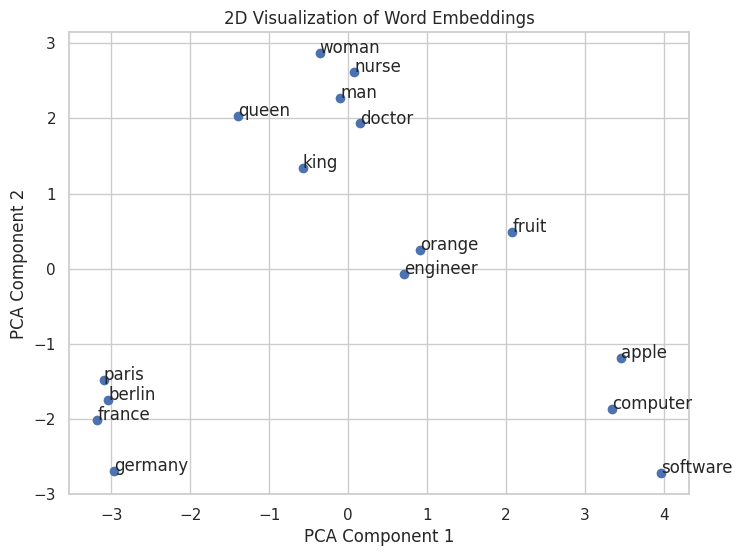

In [45]:
plt.figure(figsize=(8, 6), dpi=100)
plt.scatter(projected_vectors[:, 0], projected_vectors[:, 1])

for i, word in enumerate(words):
    if word in glove_embedding:
        plt.annotate(word, xy=(projected_vectors[i, 0], projected_vectors[i, 1]))

plt.title("2D Visualization of Word Embeddings")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

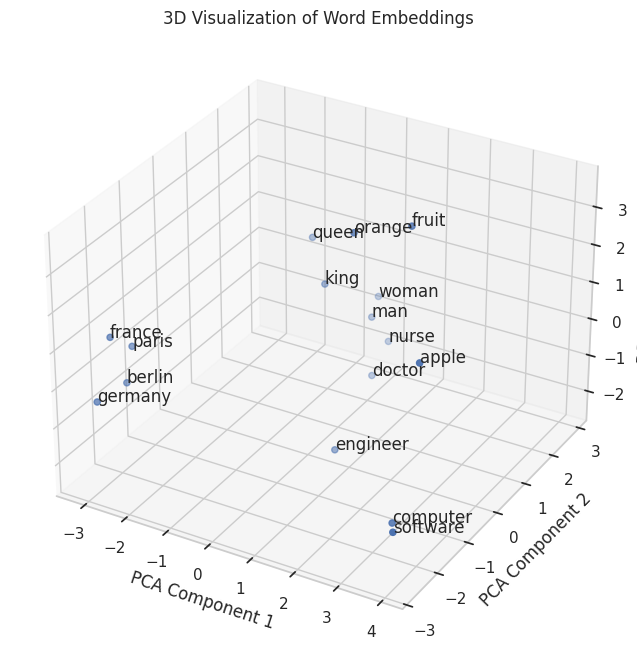

In [46]:
from mpl_toolkits.mplot3d import Axes3D

# Apply PCA for 3D
pca_3d = PCA(n_components=3)
reduced_vectors_3d = pca_3d.fit_transform(word_vectors)

# Plotting 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(reduced_vectors_3d[:, 0], reduced_vectors_3d[:, 1], reduced_vectors_3d[:, 2])

for i, word in enumerate(words):
    if word in glove_embedding:
        ax.text(reduced_vectors_3d[i, 0], reduced_vectors_3d[i, 1], reduced_vectors_3d[i, 2], word)

ax.set_title("3D Visualization of Word Embeddings")
ax.set_xlabel("PCA Component 1")
ax.set_ylabel("PCA Component 2")
ax.set_zlabel("PCA Component 3")
plt.show()


## **T-SNE**

,x,y,label
0,2.110331,-1.995508,king
1,2.185714,-1.860604,queen
2,1.341245,-1.515660,man
3,1.351627,-1.480515,woman
4,1.182382,-1.678388,child


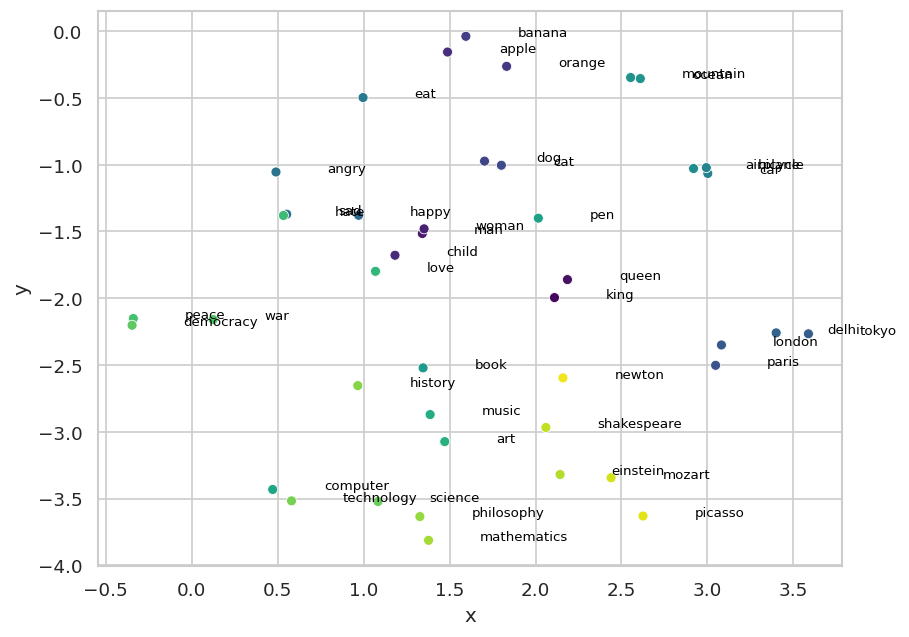

In [47]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler

def visualize_embeddings(words, embeddings):
    vectors = np.array([embeddings[word] for word in words if word in embeddings])
    labels = [word for word in words if word in embeddings]

    tsne = TSNE(n_components=2, random_state=0)
    vectors_2d = tsne.fit_transform(vectors)

    # Create a DataFrame for Seaborn
    df = pd.DataFrame(vectors_2d, columns=['x', 'y'])
    df['label'] = labels
    display(df.head())


    plt.figure(figsize=(8, 6),dpi=120)
    sns.set(style="whitegrid")
    scatter = sns.scatterplot(data=df, x='x', y='y', palette='viridis', hue='label', legend=False)

    # Add labels
    for i, label in enumerate(df['label']):
        scatter.text(df.x[i]+0.3, df.y[i], df.label[i], horizontalalignment='left', fontsize=8, color='black')

    plt.show()

words = [
    'king', 'queen', 'man', 'woman', 'child', 'apple', 'orange', 'banana', 'dog', 'cat',
    'paris', 'london', 'new york', 'tokyo', 'delhi', 'happy', 'sad', 'angry',
    'eat', 'car', 'bicycle', 'airplane', 'mountain', 'ocean',
    'book', 'pen', 'computer', 'music', 'art', 'love', 'hate', 'peace', 'war', 'democracy',
    'science', 'technology', 'history', 'philosophy', 'mathematics', 'einstein', 'shakespeare', 'mozart', 'picasso', 'newton'
]

visualize_embeddings(words, glove_embedding)


## **Gender Bias**

In [50]:
def gender_bias(embeddings, word_list):
    gender_direction = embeddings['woman'] - embeddings['man']
    for word in word_list:
        bias = cosine_similarity(gender_direction, embeddings[word])
        print(f"Gender bias in '{word}': {bias}")

print("Positive means the word is closer to woman, negative means man")
gender_bias(glove_embedding, ['nurse', 'engineer', 'submissive', 'dominant'])

Positive means the word is closer to woman, negative means man
Gender bias in 'nurse': 0.38030879680687524
Gender bias in 'engineer': -0.0803928049452407
Gender bias in 'submissive': 0.2966289629269361
Gender bias in 'dominant': -0.10219204457311465


In [56]:
def debias_embeddings(embeddings, bias_direction):
    debiased_embeddings = {}
    for word, vector in tqdm(embeddings.items()):
        projection = vector.dot(bias_direction)  * bias_direction / np.linalg.norm(bias_direction)
        debiased_embeddings[word] = vector - projection
    return debiased_embeddings

gender_direction = glove_embedding['woman'] - glove_embedding['man']
debiased_embeddings = debias_embeddings(glove_embedding, gender_direction)

  0%|          | 0/400000 [00:00<?, ?it/s]

In [57]:
gender_bias(debiased_embeddings, ['nurse', 'engineer', 'submissive', 'dominant'])

Gender bias in 'nurse': -0.07689577389184654
Gender bias in 'engineer': -0.04313187588400992
Gender bias in 'submissive': 0.006551885441591728
Gender bias in 'dominant': -0.0354499328795655
